# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

##### 1.Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [2]:
data = pd.read_csv('my_PJME_MW.csv',  parse_dates = {'Date Time' : [0, 1]} )
data = data.set_index('Date Time')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 12 columns):
PJME_MW            145374 non-null float64
year               145374 non-null int64
month              145374 non-null int64
dayofmonth         145374 non-null int64
quarter            145374 non-null int64
dayofyear          145374 non-null int64
weekofyear         145374 non-null int64
dayofweek          145374 non-null int64
hour               145374 non-null int64
is_holiday         145374 non-null int64
is_prev_holiday    145374 non-null int64
is_next_holiday    145374 non-null int64
dtypes: float64(1), int64(11)
memory usage: 14.4 MB


In [3]:
data.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date Time,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01 02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01 03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01 04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01 05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [4]:
data_m = data.resample('M').mean()

##### 2. Подберите параметры модели SARIMAX для этого ряда.

In [5]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

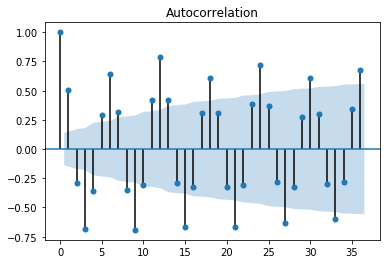

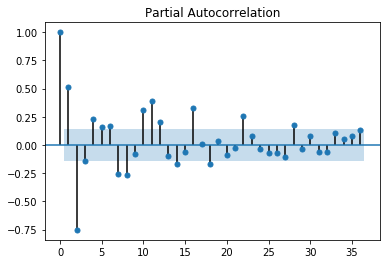

In [6]:
LAGS = 36
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values, lags=LAGS)
plt.show()
sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values, lags=LAGS)
plt.show()

Ряд  - сезонный.  
Сохраняется  корреляция в 1, 6, 12, 18, 24, 30, 36 месяцы и обратная корреляция в 3, 9, 15, 21, 27, 33 месяцы.  
Для разностей важными являются значения внутри первых 3-х значений   
Следует использовать модель сезонности с периодом 6, 12, 18, 24, 30, 36 месяца. 

In [7]:
import itertools

LAGS = 12
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], LAGS) for x in list(itertools.product(p, d, q))]

In [8]:
from tqdm import tqdm
warnings.filterwarnings('ignore')

best_aic = None
best_param = None
best_seasonal = None
best_model = None
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-LAGS],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            #print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if (best_aic is None) or (best_aic > results.aic):
                best_aic = results.aic
                best_param = param
                best_seasonal = param_seasonal 
                best_model = mod
        except:
            continue
            
print('ARIMA{}x{} - AIC:{}'.format(best_param, best_seasonal, best_aic))

100%|██████████████████████████████████████████| 27/27 [33:07<00:00, 73.60s/it]


ARIMA(1, 1, 2)x(1, 2, 2, 12) - AIC:2438.8065320932105


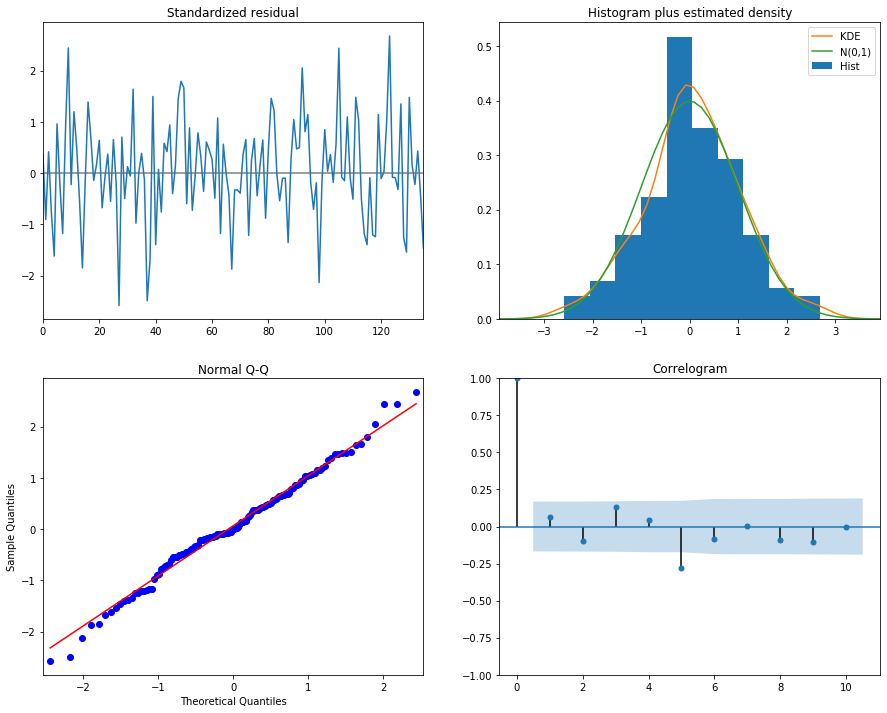

In [10]:
results = best_model.fit()
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Диагностика показала, что остатки модели распределяются близко к нормальному распределению.

Значит выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

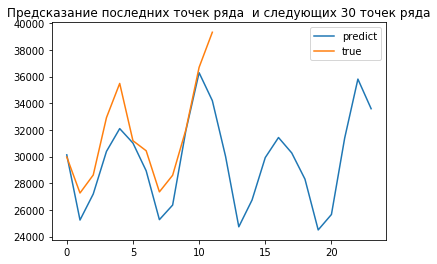

In [22]:
pred_dynamic = results.forecast(LAGS*2)    #делаем предсказание на 1 год известный и еще 1 год

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(data_m['PJME_MW'].values[-LAGS:],label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

Модель полученная на уроке:

In [25]:
data_w = data.resample('w').mean()
mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[:-12],order=[0,0,1],
                                seasonal_order=[1,1,2,26] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 14254.936602964823


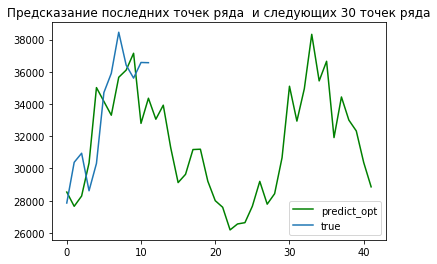

In [26]:
 #делаем предсказание на 3 точки от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(42)

plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_w['PJME_MW'].values[-12:], label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

##### 3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Модель, построеная на месячных значения, хорошо отражает сезонность в отличии от модели на недельных данных, вероятно из-за отсутствия в модели последней авторегрессионной составляющей и порядка интегрирования.
